In [2]:
import matplotlib.pyplot as plt 
from collections import Counter 
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_recall_curve, auc
from imblearn.ensemble import BalancedBaggingClassifier

In [3]:
# Load the dataset
data_cleaned = pd.read_csv('data_cleaned.csv')

In [4]:
corr = data_cleaned.corr()
strong_correlation_cols = [col for col in corr.columns if abs(corr.loc['HadHeartAttack', col]) >= 0.05 and col != 'HadHeartAttack']

# 检查并将映射后的列转换为整数类型
for col in data_cleaned.columns:
    if data_cleaned[col].dtype == 'object':
        print(f"Warning: Column {col} is still of type 'object'. Attempting to convert.")
    # 尝试将列转换为整数类型
    data_cleaned[col] = data_cleaned[col].astype('int', errors='ignore')
print(data_cleaned.dtypes)

# Select features (X) and target (y)
X = data_cleaned[strong_correlation_cols]
y = data_cleaned['HadHeartAttack'].astype('int')  # 确保目标变量是整数类型

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Unnamed: 0                   int64
State                        int64
Sex                          int64
GeneralHealth                int64
PhysicalHealthDays           int64
MentalHealthDays             int64
LastCheckupTime              int64
PhysicalActivities           int64
SleepHours                   int64
RemovedTeeth                 int64
HadHeartAttack               int64
HadAngina                    int64
HadStroke                    int64
HadAsthma                    int64
HadSkinCancer                int64
HadCOPD                      int64
HadDepressiveDisorder        int64
HadKidneyDisease             int64
HadArthritis                 int64
HadDiabetes                  int64
DeafOrHardOfHearing          int64
BlindOrVisionDifficulty      int64
DifficultyConcentrating      int64
DifficultyWalking            int64
DifficultyDressingBathing    int64
DifficultyErrands            int64
SmokerStatus                 int64
ECigaretteUsage              int64
ChestScan           

In [5]:
def knn_train(X_train, y_train):
    # 训练模型
    knn = KNeighborsClassifier(n_neighbors = 3)
    knn.fit(X_train, y_train)

    return knn

def model_predict(model, X_train, X_test):
    # 测试模型
    y_train_predict = model.predict(X_train)
    y_test_predict  = model.predict(X_test)

    return y_train_predict, y_test_predict

In [6]:
def model_metrics(model, X_train, y_train, X_test, y_test, y_train_predict, y_test_predict):
    # 计算模型评估指标
    target_classes = ['HadHeartAttack_No','HadHeartAttack_Yes']
    print("Training Dataset")
    print("_"*60)
    print(classification_report(y_train, y_train_predict, target_names = target_classes))
    print("_"*60)
    print("Training set accuracy: {:.4f}".format(model.score(X_train, y_train)))
    print("_"*60)
    print("#"*60)
    print("Testing Dataset")
    print("_"*60)
    print(classification_report(y_test, y_test_predict, target_names = target_classes))
    print("_"*60)
    print("Testing set accuracy: {:.4f}".format(model.score(X_test, y_test)))
    print("_"*60)
    print("#"*60)

In [7]:
def plot_roc(model, X_test, y_test):
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    
    lr_probs = model.predict_proba(X_test)
    lr_probs = lr_probs[:,1]
    lr_auc = roc_auc_score(y_test, lr_probs)
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [8]:
def plot_cm(y_test, y_test_predict):
    cm = confusion_matrix(y_test, y_test_predict)
    plt.figure(figsize=(6, 4))
    cm_matrix = pd.DataFrame(data = cm, columns = ['Predict Negative:0', 'Predict Positive:1'],
                                    index = ['Actual Negative:0', 'Actual Positive:1'])

    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [9]:
def bbc_train(X_train, y_train):
    bbc = BalancedBaggingClassifier(estimator=KNeighborsClassifier(n_neighbors = 3),
                                    sampling_strategy = 'auto',
                                    replacement = False,
                                    random_state = 42)
    bbc.fit(X_train, y_train)

    return bbc

Training Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.97      0.99      0.98    186020
HadHeartAttack_Yes       0.73      0.43      0.54     10790

          accuracy                           0.96    196810
         macro avg       0.85      0.71      0.76    196810
      weighted avg       0.95      0.96      0.95    196810

____________________________________________________________
Training set accuracy: 0.9599
____________________________________________________________
############################################################
Testing Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.96      0.98      0.97     46558
HadHeartAttack_Yes       0.40      0.23      0.29      2645

          accuracy                           0.94     49203
         macro avg       0.

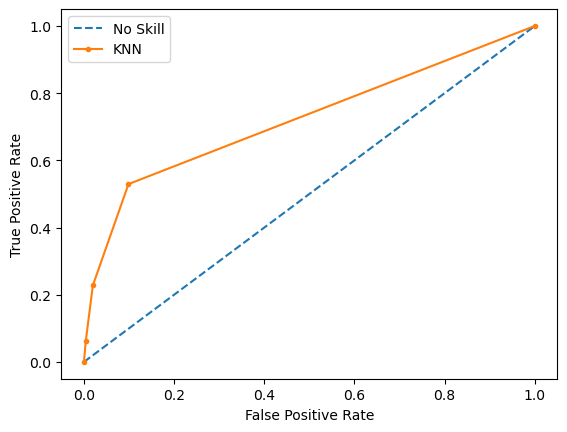

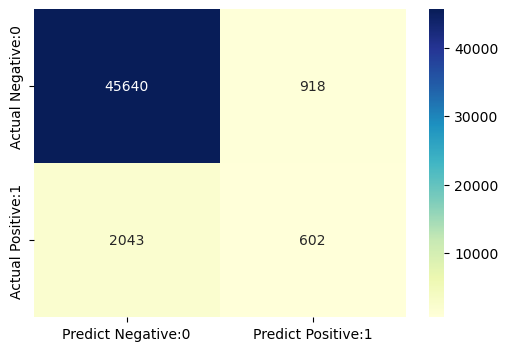

In [ ]:
knn = knn_train(X_train, y_train)
print(f"KNN Model Training Complete...")
knn_train_predict, knn_test_predict = model_predict(knn, X_train, X_test)
model_metrics(knn, X_train, y_train, X_test, y_test, knn_train_predict, knn_test_predict)
plot_roc(knn, X_test, y_test)
plot_cm(y_test, knn_test_predict)

Training Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.99      0.82      0.90    186020
HadHeartAttack_Yes       0.22      0.85      0.34     10790

          accuracy                           0.82    196810
         macro avg       0.60      0.84      0.62    196810
      weighted avg       0.95      0.82      0.87    196810

____________________________________________________________
Training set accuracy: 0.8223
____________________________________________________________
############################################################
Testing Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.98      0.82      0.89     46558
HadHeartAttack_Yes       0.19      0.74      0.30      2645

          accuracy                           0.81     49203
         macro avg       0.

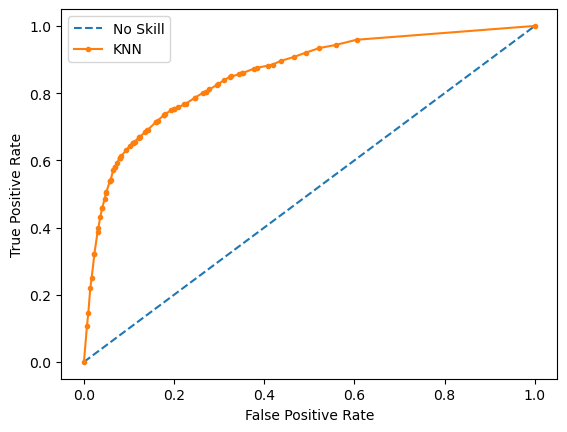

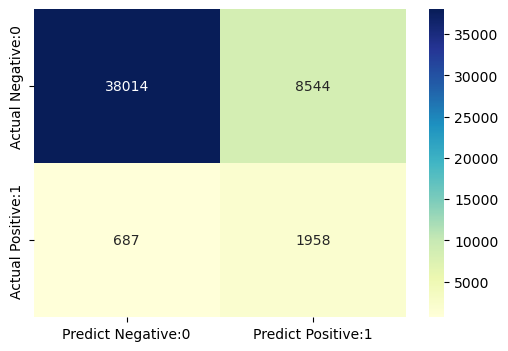

In [ ]:
bbc = bbc_train(X_train, y_train)
print(f"BBC Model Training Complete...")
bbc_train_predict, bbc_test_predict = model_predict(bbc, X_train, X_test)
model_metrics(bbc, X_train, y_train, X_test, y_test, bbc_train_predict, bbc_test_predict)
plot_roc(bbc, X_test, y_test)
plot_cm(y_test, bbc_test_predict)

In [ ]:
from imblearn.over_sampling import SMOTE

# 使用SMOTE算法对训练集进行过采样
sm = SMOTE(random_state = 42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

KNN Model Training Complete...
Training Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.97      0.95      0.96    186020
HadHeartAttack_Yes       0.95      0.98      0.96    186020

          accuracy                           0.96    372040
         macro avg       0.96      0.96      0.96    372040
      weighted avg       0.96      0.96      0.96    372040

____________________________________________________________
Training set accuracy: 0.9618
____________________________________________________________
############################################################
Testing Dataset
____________________________________________________________
                    precision    recall  f1-score   support

 HadHeartAttack_No       0.97      0.91      0.94     46558
HadHeartAttack_Yes       0.24      0.50      0.32      2645

          accuracy                           0.89     49

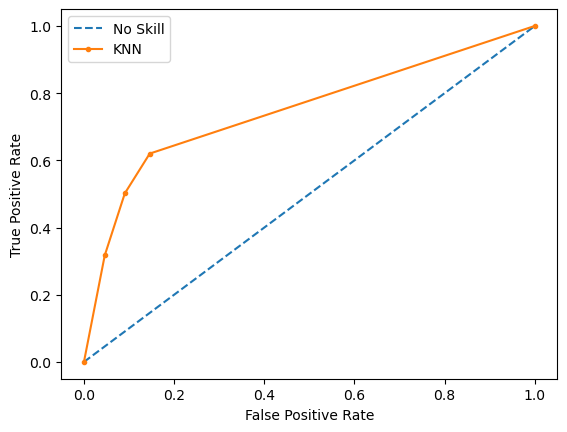

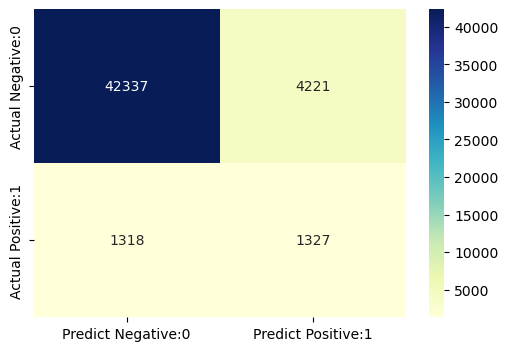

In [14]:
knn_resampled = knn_train(X_resampled, y_resampled)
print(f"KNN Model Training Complete...")
knn_resampled_train_predict, knn_resampled_test_predict = model_predict(knn_resampled, X_resampled, X_test)
model_metrics(knn_resampled, X_resampled, y_resampled, X_test, y_test, knn_resampled_train_predict, knn_resampled_test_predict)
plot_roc(knn_resampled, X_test, y_test)
plot_cm(y_test, knn_resampled_test_predict)